Version of programs and libraries used

In [20]:
import sys
import jupyterlab

print(f"Python version: {sys.version}")
print(f"Jupyter Lab verions: {jupyterlab.__version__}")

Python version: 3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]
Jupyter Lab verions: 4.0.6


In [14]:
import random
import networkx
import matplotlib

#print(f"random version: {random.__version__}") 
#does not work, version corresponds to Python version itself
print(f"networkx version: {networkx.__version__}")
print(f"matplotlib verion: {matplotlib.__version__}")

networkx version: 3.1
matplotlib verion: 3.8.0


Graph definition

In [21]:
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]

Graph usefull function

In [31]:
# Build Graph in networkx format
# Use Graph naming convention to imply networkx usage
def build_Graph(V, E):
    Graph = networkx.Graph()
    Graph.add_nodes_from(V)
    Graph.add_edges_from(E)
    return Graph

# Example
Graph = build_Graph(V, E)

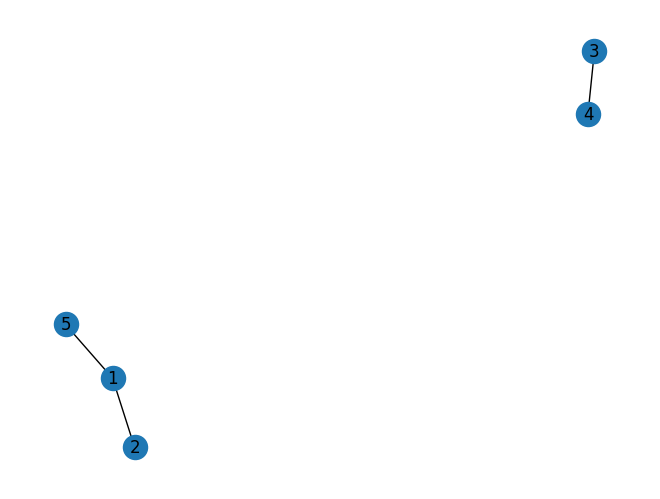

In [32]:
# Visualize Graph
def plot_graph(Graph):
    networkx.draw(Graph, with_labels=True)

plot_graph(Graph)

In [33]:
# Build graph in dictionary format, keys are nodes, values are the list of edges connected to each nodes
# graph naming convection for this format
def build_graph(V, E):
    return {i: [j for j in V if j!=i and (i, j) in E or (j, i) in E] for i in V}

graph = build_graph(V, E)
print(graph)

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}


Random graph generation

In [39]:
def generate_random_graph(n, k, r):
    """Set random seed to 'r' and create a graph with 'n' vertices and (up to) n * k edges."""
    random.seed(r)
    V = list(range(1,n+1))
    E = set()
    for _ in range(n*k):
        i = random.randint(1,n)
        j = random.randint(1,n)
        if i != j:
            i, j = min(i,j), max(i,j)
            E.add((i,j))
    return V, E

V, E = generate_random_graph(5, 1, 3)
print(f"V = {V}")
print(f"E = {E}")

V = [1, 2, 3, 4, 5]
E = {(4, 5), (2, 5), (3, 5), (1, 5)}


File management tools

In [40]:
def write_instance(V, E, filename):
    """Write a graph instance to a file (loosely, in a format used in DIMACS challenges)."""
    with open(filename, "w") as f:
        f.write(f"Nodes {n}\n")
        f.write(f"Edges {len(E)}\n")
        for (i,j) in E:
            f.write(f"E {i} {j}\n")

def read_instance(filename):
    """Read a graph from a file."""
    try:
        if len(filename)>3 and filename[-3:] == ".gz":  # file compressed with gzip
            import gzip
            f = gzip.open(filename, "rt")
        else:   # usual, uncompressed file
            f = open(filename)
    except IOError:
        print("could not open file", filename)
        exit(-1)

    edges = set()
    for line in f:
        if line[0:6].lower() == 'edges ':
            e, n_edges = line.split()
            n_edges = int(n_edges)
        elif line[0:6].lower() == 'nodes ':
            e, n_nodes = line.split()
            n_nodes = int(n_nodes)
        elif line[0:2].lower() == 'e ':
            e, i, j = line.split()
            i, j = int(i), int(j)
            i, j = min(i,j), max(i,j)
            edges.add((i,j))
    f.close()

    assert n_edges == len(edges)
    vertices = list(range(1,n_nodes+1))
    return vertices, list(edges)

Generate random graphs using predefined random seeds and write them to files

In [44]:
#for n in [100, 1000, 10000, 100000, 1000000]:
#    for k in [1, 2, 5, 10]:
#        for r in range(1,11):
#            V, E = generate_random_graph(n, k, r)
#            filename = f"graphs/G{n}-{k}-{r}.graph"
#            write_instance(V, E, filename)

networkx method for finding the number of connected components in a graph

In [49]:
def default_method(V, E):
    G = networkx.Graph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    return len(list(networkx.connected_components(G)))
    
# graph visulized previously
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]
print(build_graph(V, E))
print(f"no. of connected components: {default_method(V,E)}")

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}
no. of connected components: 2


Alternative method for finding the number of connected components in a graph

In [52]:
class my_no_connected_components:
    def __init__(self, g):
        self.g = g
        self.visited = {}
        self.V = g.keys()
        self.ncc = 0
        for k in self.V:
            self.visited[k] = self.visited.get(k, False)

    def find(self):
        for k in self.V:
            if self.visited[k] == False:
                self.dfs(k)
                self.ncc+=1
        return self.ncc

    def dfs(self, k):
        self.visited[k] = True
        for p in self.g[k]:
            if self.visited[p] == False:
                self.dfs(p)

def alternative_method(V, E):
    return my_no_connected_components(build_graph(V,E)).find()

# graph visulized previously
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]
print(build_graph(V, E))
print(f"no. of connected components: {alternative_method(V,E)}")

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}
no. of connected components: 2


Read graphs from files and solving them using both the default method and the alternative method, computing the cpu seconds, and writing that comparison data to files

In [60]:
with open("results", "w") as f:
    f.write(f"{:<8} {:<9} {:<9} {:<10}".format('nV','nE','ncc','cpu_seconds')")
    for n in [100]:
        for k in [1]:
            for r in range(1,2):
                # read graph from file
                graph_filename = f"graphs/G{n}-{k}-{r}.graph"
                V, E = read_instance(graph_filename)
                
                # defult method
                start = time.process_time()
                ncomponents_default = default_method(V,E)
                end = time.process_time()
                cpu_default = end - start
                print(f"{graph_filename}: {ncomponents_default} components, {cpu_default} seconds")
                f.write(f"{:<8} {:<9} {:<9} {:<10}".format(len(V), len(E), ncomponents_deault, cpu_default))
                # alternative method
                start = time.process_time()
                ncomponents_alternative = alternative_method(V,E)
                end = time.process_time()
                cpu_alternative = end - start
                print(f"{graph_filename}: {ncomponents_alternative} components, {cpu_alternative} seconds")
                f.write(f"{:<8} {:<9} {:<9} {:<10}".format(len(V), len(E), ncomponents_alternative, cpu_alternative))
                
                if ncomponents != my_ncomponents:
                    print("Error")
                    exit(-1)
                


SyntaxError: unterminated string literal (detected at line 2) (2192531241.py, line 2)

In [57]:
print ("{:<8} {:<9} {:<9} {:<10}".format('nV','nE','ncc','cpu_seconds'))
for a, b, c, d in [[1, 2, 3, 4], [5, 6, 7, 9]]:
    print ("{:<8} {:<9} {:<9} {:<10}".format(a, b, c, d))

nV       nE        ncc       cpu_seconds
1        2         3         4         
5        6         7         9         


In [55]:
len("10000000")

8